In [27]:
import sys
sys.path.append("/home/mdzik/rysy/TCLB_tools/Python")

import h5py
import numpy as np
import matplotlib.pyplot as plt
from display_xml import XML
import CLB.CLBXMLWriter as CLBXML   
from skimage import measure


In [28]:
def fft_sol(initial_condition, diffusivity, lambda_phi, time):
    L = initial_condition.shape[0]

    
    _diffusivity = diffusivity * (L /( 2 * np.pi))**2
    _time = time
    
    F = np.fft.fft2(initial_condition)   
    n = L
    x2 = np.array([ float(i) if i < n/2 else float(-(n-i)) for i in range(0,n)])
    k2, k1 = np.meshgrid(x2, x2)
    k1 *= 2.*np.pi/L
    k2 *= 2.*np.pi/L

    tmp = -_time*(_diffusivity*(k1**2+ k2**2 ) + lambda_phi)
    decay = np.exp(tmp)
    yinv = np.fft.ifft2(np.multiply(F,decay))
    P = np.real(yinv) # ignore imaginary artifacts
    return P


0 0 0
/bin/bash: tclb: command not found


<ipython-input-30-5b44f2ef25c1>:27: RuntimeWarning: invalid value encountered in double_scalars
  diff_lbm =  0.04 *  space_factor**2 / time_factor
<ipython-input-30-5b44f2ef25c1>:29: RuntimeWarning: divide by zero encountered in true_divide
  lambda_lbm = 1. / time_factor
<ipython-input-30-5b44f2ef25c1>:74: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File('./output/LinearReaction_HDF5_%08d.h5'%time)


OSError: Unable to create file (unable to open file: name = './output/LinearReaction_HDF5_00000000.h5', errno = 2, error message = 'No such file or directory', flags = 15, o_flags = c2)

<Figure size 432x288 with 0 Axes>

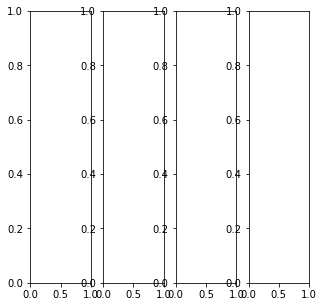

In [30]:
shapes_trapez = list()
shapes_heun = list()
shapes_euler = list()
shapes_midpoint = list()

all_factors = np.arange(20)
factors = list()

spatial = True


t_factors, s_factors = np.meshgrid(all_factors,all_factors)
t_factors = t_factors**2

for factor_id,(time_factor, space_factor) in enumerate(zip(t_factors.ravel(), s_factors.ravel())):
    print(time_factor, space_factor, factor_id)
    domain_size = 10 * space_factor
    time = 1 * time_factor

    CLBc = CLBXML.CLBConfigWriter( )

    CLBc.addGeomParam('nx', domain_size)
    CLBc.addGeomParam('ny', domain_size)

    CLBc.addCollisionBlock(name='TRT_M')
    CLBc.addBox()
    diff_lbm =  0.04 *  space_factor**2 / time_factor

    lambda_lbm = 1. / time_factor    
    params = {
            "Diffusivity_PHI": diff_lbm,
            "Init_PHI":0.1,
            "LinearReactionRate":  -lambda_lbm
    }

    CLBc.addModelParams(params)

    
    CLBc.addRunR(eval=\
        """
                x = Solver$Geometry$X 
                x = (x - 0.5)/ ({domain_size}) * 2 * pi
                y = Solver$Geometry$Y
                y = (y - 0.5)/ ({domain_size}) * 2 * pi
                Solver$Fields$Init_PHI_External[] = exp(sin(x)) + 2*exp(sin(2*y)) # to benchmark diffusion & source term
                #Solver$Fields$Init_PHI_External[] = sin(x) + sin(2*y) # to benchmark diffusion & source term
                
                Solver$Actions$InitFromExternalAction()        
        """.format(domain_size=domain_size))

    CLBc.addHDF5()
    solve = CLBc.addSolve(iterations=time)
    CLBc.addHDF5(Iterations=time/10, parent=solve)
    CLBc.addHDF5()

    CLBc.write('LinearReaction.xml')

#     #f = open('AllenCahnTrapezoidal.xml', 'r')
#     #XML(''.join(f.readlines()))

    ! rm -rf ./output/LinearReaction* && tclb d2q9_reaction_diffusion_system_LinearReaction_Trapezoidal LinearReaction.xml > /dev/null

    # TimeSteps2 = list()
    plt.figure()
    fig, axs = plt.subplots(1,4,figsize=(5,5))
     # fig, axs = plt.subplots(1,2,figsize=(5,5))
    # for ax,i in zip(axs.ravel(), range(0,time,int(time/10))[:2]):
    #     f = h5py.File('./output/AllenCahnTrapezoidal_HDF5_%08d.h5'%i)    
    #     figid = figid + 1
    #     ax.imshow(f['PHI'][0,:,:])
    #     ax.set_title(i)
    # plt.tight_layout()
    ax = axs[0]
    f = h5py.File('./output/LinearReaction_HDF5_%08d.h5'%time)    
    ax.imshow(f['PHI'][0,:,:])

    shapes_trapez.append(f['PHI'][0,:,:])
    
 
    ! rm -rf ./output/LinearReaction* && tclb d2q9_reaction_diffusion_system_LinearReaction_Heun LinearReaction.xml > /dev/null

    # TimeSteps2 = list()
    # plt.figure()
    # fig, axs = plt.subplots(1,2,figsize=(5,5))
    # for ax,i in zip(axs.ravel(), range(0,time,int(time/10))[:2]):
    #     f = h5py.File('./output/AllenCahnTrapezoidal_HDF5_%08d.h5'%i)    
    #     figid = figid + 1
    #     ax.imshow(f['PHI'][0,:,:])
    #     ax.set_title(i)
    # plt.tight_layout()
    ax = axs[1]
    f = h5py.File('./output/LinearReaction_HDF5_%08d.h5'%time)    
    ax.imshow(f['PHI'][0,:,:])
    
    shapes_heun.append(f['PHI'][0,:,:])
    

    ! rm -rf ./output/LinearReaction* && tclb d2q9_reaction_diffusion_system_LinearReaction_Midpoint LinearReaction.xml > /dev/null

    # TimeSteps2 = list()
    # plt.figure()
    # fig, axs = plt.subplots(1,2,figsize=(5,5))
    # for ax,i in zip(axs.ravel(), range(0,time,int(time/10))[:2]):
    #     f = h5py.File('./output/AllenCahnTrapezoidal_HDF5_%08d.h5'%i)    
    #     figid = figid + 1
    #     ax.imshow(f['PHI'][0,:,:])
    #     ax.set_title(i)
    # plt.tight_layout()
    ax = axs[2]
    f = h5py.File('./output/LinearReaction_HDF5_%08d.h5'%time)    
    ax.imshow(f['PHI'][0,:,:])
    
    shapes_midpoint.append(f['PHI'][0,:,:])    

    ! rm -rf ./output/LinearReaction* && tclb d2q9_reaction_diffusion_system_LinearReaction_Euler LinearReaction.xml > /dev/null

    # TimeSteps2 = list()
    # plt.figure()
    # fig, axs = plt.subplots(1,2,figsize=(5,5))
    # for ax,i in zip(axs.ravel(), range(0,time,int(time/10))[:2]):
    #     f = h5py.File('./output/AllenCahnTrapezoidal_HDF5_%08d.h5'%i)    
    #     figid = figid + 1
    #     ax.imshow(f['PHI'][0,:,:])
    #     ax.set_title(i)
    # plt.tight_layout()
    ax = axs[3]
    f = h5py.File('./output/LinearReaction_HDF5_%08d.h5'%time)    
    ax.imshow(f['PHI'][0,:,:])
    
    shapes_euler.append(f['PHI'][0,:,:])
    plt.tight_layout()
    plt.show()
    
    np.savez('shapes.npz', shapes_trapez, shapes_heun, shapes_euler, shapes_midpoint)
    
 


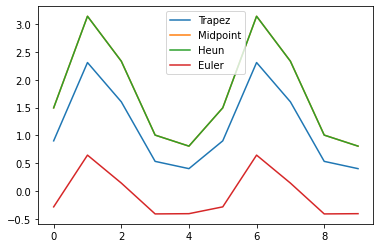

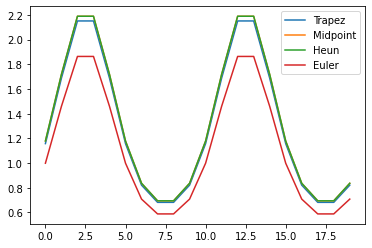

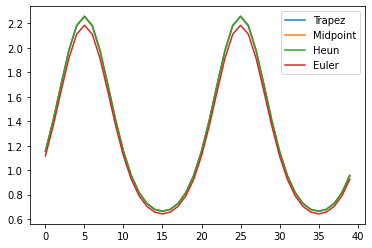

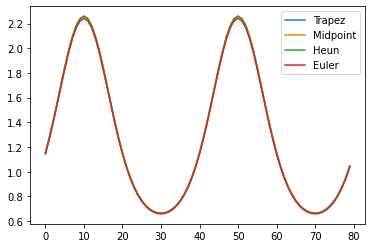

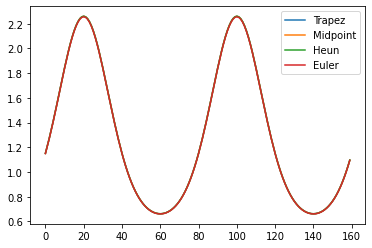

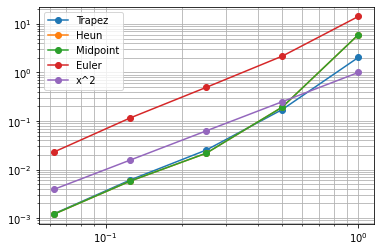

In [312]:
l2_trapez = list()
l2_heun = list()
l2_euler = list()
l2_midpoint = list()

for n, shape_trapez, shape_heun, shape_euler, shape_midpoint in zip(factors[:-1], shapes_trapez[:-1], shapes_heun[:-1], shapes_euler[:-1], shapes_midpoint[:-1]):
    plt.figure()
    plt.plot(shape_trapez[:,0], label='Trapez')   
    plt.plot(shape_heun[:,0], label='Midpoint')   
    plt.plot(shape_heun[:,0], label='Heun')   
    plt.plot(shape_euler[:,0], label='Euler')   
    plt.legend()
    #plt.plot(shapes_trapez[-1][:,0])
    
    l2_trapez.append(np.sqrt( np.sum((shape_trapez[::n,::n] - shapes_trapez[-1][::factors[-1],::factors[-1]])**2 )))
    l2_heun.append(np.sqrt( np.sum((shape_heun[::n,::n] - shapes_heun[-1][::factors[-1],::factors[-1]])**2 )))
    l2_euler.append(np.sqrt( np.sum((shape_euler[::n,::n] - shapes_euler[-1][::factors[-1],::factors[-1]])**2 )))
    l2_midpoint.append(np.sqrt( np.sum((shape_midpoint[::n,::n] - shapes_midpoint[-1][::factors[-1],::factors[-1]])**2 )))    

plt.figure()
plt.loglog(1/np.array(all_factors[:-1]), l2_trapez, 'o-', label='Trapez')    
plt.loglog(1/np.array(all_factors[:-1]), l2_heun, 'o-', label='Heun')    
plt.loglog(1/np.array(all_factors[:-1]), l2_midpoint, 'o-', label='Midpoint')    
plt.loglog(1/np.array(all_factors[:-1]), l2_euler, 'o-', label='Euler')


plt.loglog(1/np.array(all_factors[:-1]), 1/np.array(all_factors[:-1])**2, 'o-', label='x^2')   

plt.legend()
plt.grid(which='both')

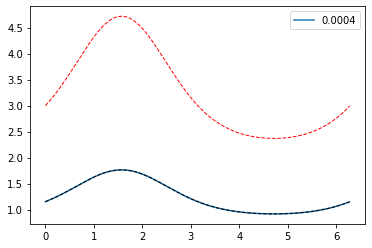

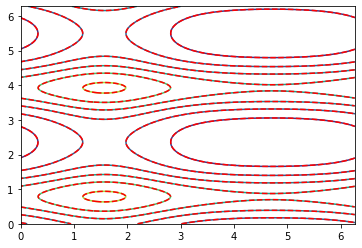

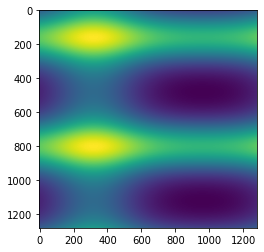

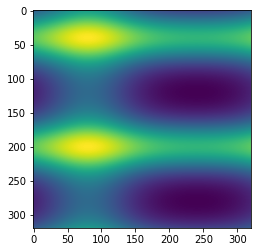

In [313]:
Nfft = domain_size*4
lx = np.arange(Nfft)
lx = (lx)/ (Nfft) * 2 * np.pi 
X,Y = np.meshgrid(lx,lx)

F0 = np.exp(np.sin(X)) + 2*np.exp(np.sin(2*Y))

Nlb = len(f['PHI'][0,0,:])
lxlb = np.arange(Nlb)
lxlb = (lxlb)/ (Nlb) * 2 * np.pi 
Xlb,Ylb = np.meshgrid(lxlb,lxlb)


diff_fft = 1


t0_lb = Nlb**2 / diff_lbm 
t0_fft = (np.pi*2)**2 / diff_fft 

lambda_fft =  lambda_lbm  * t0_lb / t0_fft 

Tnd = time / t0_lb 
plt.plot(Xlb[0,:],shapes_trapez[-1][0,:], label=Tnd)
   
FFT_Solution = fft_sol(F0, diff_fft, lambda_fft, Tnd*t0_fft  )

plt.plot(X[0,:],FFT_Solution[0,:], 'k--', lw=1)
plt.plot(X[0,:],F0[0,:], 'r--', lw=1)

plt.legend()
plt.figure()


plt.contour(X,Y,FFT_Solution)
plt.contour(Xlb,Ylb,shapes_trapez[-1][:,:], colors='r', linestyles='--')

plt.figure()

plt.imshow(FFT_Solution)
plt.figure()
plt.imshow(shapes_trapez[-1][:,:])
           

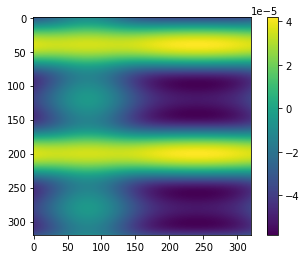

In [314]:
plt.imshow((FFT_Solution[::4,::4] - shapes_trapez[-1]) / FFT_Solution[::4,::4])
plt.colorbar()

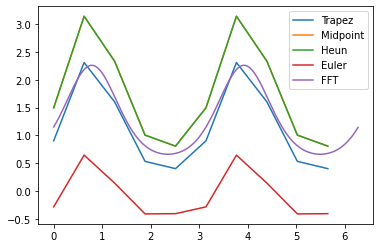

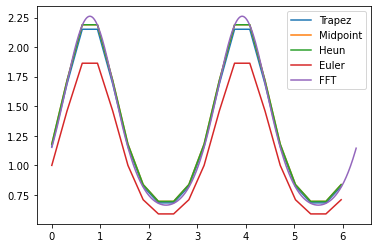

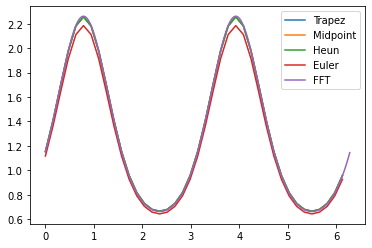

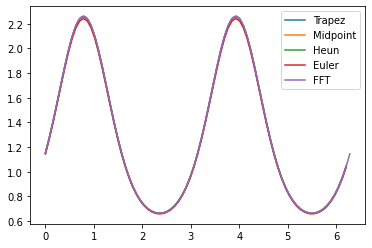

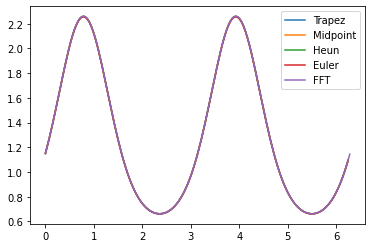

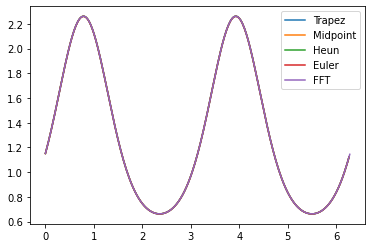

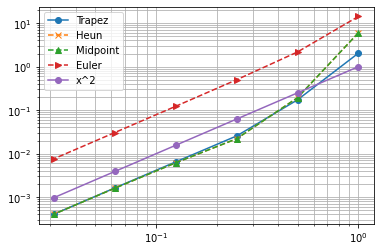

In [315]:
l2_trapez = list()
l2_heun = list()
l2_euler = list()
l2_midpoint = list()

for n, shape_trapez, shape_heun, shape_euler, shape_midpoint in zip(factors, shapes_trapez, shapes_heun, shapes_euler, shapes_midpoint):
    plt.figure()
    plt.plot(Ylb[::int(factors[-1]/n),0], shape_trapez[:,0], label='Trapez')   
    plt.plot(Ylb[::int(factors[-1]/n),0], shape_heun[:,0], label='Midpoint')   
    plt.plot(Ylb[::int(factors[-1]/n),0], shape_heun[:,0], label='Heun')   
    plt.plot(Ylb[::int(factors[-1]/n),0], shape_euler[:,0], label='Euler')   
    plt.plot(Y[:,0], FFT_Solution[:,0], label='FFT')
    plt.legend()
   # plt.show()
    #sdfsdf
    #plt.plot(shapes_trapez[-1][:,0])
    
    l2_trapez.append(np.sqrt( np.sum((shape_trapez[::n,::n] - FFT_Solution[::4,::4][::factors[-1],::factors[-1]])**2 )))
    l2_heun.append(np.sqrt( np.sum((shape_heun[::n,::n] - FFT_Solution[::4,::4][::factors[-1],::factors[-1]])**2 )))
    l2_euler.append(np.sqrt( np.sum((shape_euler[::n,::n] - FFT_Solution[::4,::4][::factors[-1],::factors[-1]])**2 )))
    l2_midpoint.append(np.sqrt( np.sum((shape_midpoint[::n,::n] - FFT_Solution[::4,::4][::factors[-1],::factors[-1]])**2 )))    

plt.figure()
plt.loglog(1/np.array(all_factors), l2_trapez, 'o-', label='Trapez')    
plt.loglog(1/np.array(all_factors), l2_heun, 'x--', label='Heun')    
plt.loglog(1/np.array(all_factors), l2_midpoint, '^--', label='Midpoint')    
plt.loglog(1/np.array(all_factors), l2_euler, '>--', label='Euler')


plt.loglog(1/np.array(factors), 1/np.array(factors)**2, 'o-', label='x^2')   

plt.legend()
plt.grid(which='both')

## Stability analysis

In [2]:
w = np.array([16,4,4,4,4,1,1,1,1]) / 36
w

array([0.44444444, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
       0.02777778, 0.02777778, 0.02777778, 0.02777778])

In [61]:
eigens = list()
for lam in -np.logspace(-4,0,100):

    A = np.eye(9,9)

    for i in range(9):
        A[i,:] -= lam*w[i] / 2


    max_eigen = np.max(np.absolute(np.linalg.eigvals(np.linalg.inv(A))))
    min_eigen = np.min(np.absolute(np.linalg.eigvals(np.linalg.inv(A))))
    
    eigens.append((lam, max_eigen, min_eigen))
    
for lam in np.logspace(-4,0,100):
    
    A = np.eye(9,9)

    for i in range(9):
        A[i,:] -= lam*w[i] / 2


    max_eigen = np.max(np.absolute(np.linalg.eigvals(np.linalg.inv(A))))
    min_eigen = np.min(np.absolute(np.linalg.eigvals(np.linalg.inv(A))))
    
    eigens.append((lam, max_eigen, min_eigen))    

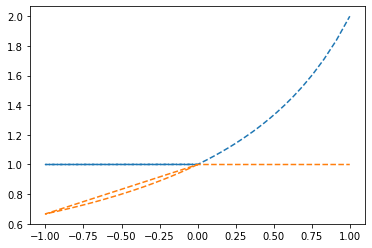

In [62]:
eigens = np.array(eigens)

plt.plot(eigens[:,0],eigens[:,1],'--')
plt.plot(eigens[:,0],eigens[:,2],'--')

In [42]:
np.absolute(np.linalg.eigvals(np.linalg.inv(A)))

array([1.        , 0.66666667, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        ])

In [87]:
dx = [-1,0,1]
eX,eY = np.meshgrid(dx,dx)
e = np.array([eX.ravel(),eY.ravel()]).T

eL = np.linalg.norm(e, axis=1)

wE = np.zeros_like(w)
wE[eL==0] = 16/36.
wE[eL==1] = 4/36.
wE[eL>1] = 1/36.


In [258]:



N = 5
psi = np.linspace(0,2*np.pi,N)
Psi_s = np.array(np.meshgrid(psi,psi)).reshape(2,N**2).T

u_s = np.array([np.sin(psi), np.cos(psi)]).T

eigensU_Tau = list()

#for umag in np.linspace(0.01,1,10):
for lam in np.linspace(-2,0,10):
    for tau in np.linspace(0.4,2,10):
        max_eigen = 0
        max_eigen_euler = 0
        max_eigen_heun = 0
        max_eigen_trapez = 0
        for u in u_s:
            for Psi in Psi_s:

                dt = 1
                p = np.ones_like(w) # zero velocity
                #p = 1. + e.dot(umag*u)/3.

                Gamma = np.zeros((9,9),dtype=complex)

                for i in range(9):
                    for j in range(9):
                        if i == j: Gamma[i,j] = 1 - dt/(tau)
                        Gamma[i,j] +=  wE[i]*p[i]*dt/(tau)
                        Gamma[i,j] *= np.exp(-1j*dt*(Psi.dot(e[i,:]))) 

                tmp =  np.max(np.absolute(np.linalg.eigvals(Gamma)))        
                
                if max_eigen < tmp:
                    max_eigen = tmp
                    
                Xi = np.zeros((9,9),dtype=complex)
                for i in range(9):
                    for j in range(9):
                        Xi[i,j] = np.exp(-1j*dt*(Psi.dot(e[i,:])))*dt*w[i]*lam
                                          
                tmp =  np.max(np.absolute(np.linalg.eigvals(Gamma+Xi)))        
                
                if max_eigen_euler < tmp:
                    max_eigen_euler = tmp
                    
                tmp =  np.max(np.absolute(np.linalg.eigvals(Gamma+(2+lam*dt)/2.*Xi)))        
                
                if max_eigen_heun < tmp:
                    max_eigen_heun = tmp                        
        
                A = np.eye(9,9)

                for i in range(9):
                    A[i,:] -= lam*w[i] / 2     
                    
                A = np.linalg.inv(A)
                tmp =  np.max(np.absolute(np.linalg.eigvals(A @ (Gamma+1/2.*Xi))) )
                if max_eigen_trapez < tmp:
                    max_eigen_trapez = tmp   
        eigensU_Tau.append((lam, tau, max_eigen, max_eigen_euler, max_eigen_heun, max_eigen_trapez))


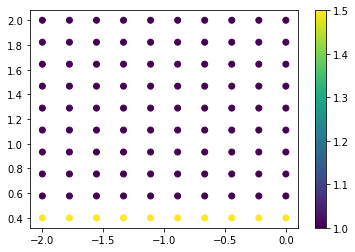

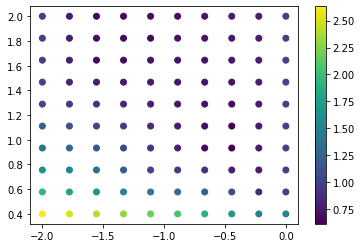

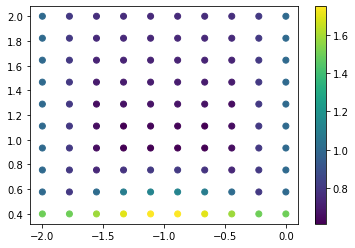

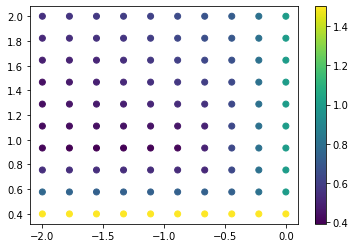

In [260]:
eigensU_Tau = np.array(eigensU_Tau)

plt.scatter(eigensU_Tau[:,0],eigensU_Tau[:,1], c=eigensU_Tau[:,2])
plt.colorbar()

plt.figure()
plt.scatter(eigensU_Tau[:,0],eigensU_Tau[:,1], c=eigensU_Tau[:,3])

maxVal = eigensU_Tau[:,3].reshape(10,10)
c_euler = np.array(measure.find_contours(maxVal, 1.0001)).T
#plt.plot(c_euler[1,:,0],c_euler[0,:,0],'r', lw=2)


plt.colorbar()

plt.figure()
plt.scatter(eigensU_Tau[:,0],eigensU_Tau[:,1], c=eigensU_Tau[:,4])
maxVal = eigensU_Tau[:,4].reshape(10,10)
c_heun = np.array(measure.find_contours(maxVal, 1.0001)).T
#plt.plot(c_euler[1,:,0],c_euler[0,:,0],'r', lw=2)


plt.colorbar()


plt.figure()
plt.scatter(eigensU_Tau[:,0],eigensU_Tau[:,1], c=eigensU_Tau[:,5])
maxVal = eigensU_Tau[:,5].reshape(10,10)
c_trapez = np.array(measure.find_contours(maxVal, 1.0001)).T
#plt.plot(c_euler[1,:,0],c_euler[0,:,0],'r', lw=2)

plt.colorbar()

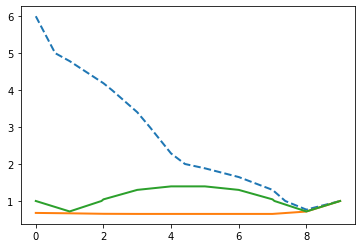

In [267]:
plt.plot(c_euler[0,:,0],c_euler[1,:,0],'--' ,lw=2)
plt.plot(c_trapez[0,:,0],c_trapez[1,:,0], lw=2)
plt.plot(c_heun[0,:,0],c_heun[1,:,0], lw=2)


In [266]:
c_euler[0,:,0]

array([0.        , 0.57174107, 1.        , 2.        , 2.25256482,
       3.        , 3.37094529, 4.        , 4.41210097, 5.        ,
       6.        , 7.        , 7.37615513, 8.        , 9.        ])